# Simulation-Based Inference for Experimental Evolution
### From ABC to Neural Posterior Estimation to Collective Inference

---
**Nadav Ben Nun** &nbsp;|&nbsp; *Gresham Lab (NYU) · Selmecki Lab (UMN)*

---

## Overview

Experimental evolution reveals the dynamics of selection, mutation, and drift — but **inferring the underlying parameters is challenging**:

- Evolution is **stochastic**: the same parameters produce variable outcomes
- We observe **discrete, noisy snapshots** of evolving populations
- There is **no closed-form likelihood**: $p(\text{data} \mid \theta)$ is analytically intractable

**Simulation-Based Inference (SBI)** solves this by learning the relationship between parameters and data directly from a simulator.

---

### Roadmap

| Section | Method | Key Feature |
|---------|--------|-------------|
| 1 | **Wright-Fisher Simulator** | Mechanistic model of GAP1 CNV dynamics |
| 2 | **ABC** | Intuitive baseline; rejection sampling |
| 3 | **NPE** | Neural density estimator; amortized inference |
| 4 | **Collective Posterior** | Formally combines evidence from multiple replicates |
| 5 | **Real Data** | *Chuong et al.* — LTRΔ line, 7 replicates, 116 generations |


In [ ]:
import sys, warnings
# CollectivePosterior implementation lives in the same directory (tutorials/)
sys.path.insert(0, '.')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pickle
from scipy.stats import gaussian_kde
from tqdm.auto import tqdm

# ── Plotting style ──────────────────────────────────────────────────────────
plt.rcParams.update({
    'font.size': 13, 'axes.titlesize': 15, 'axes.labelsize': 13,
    'xtick.labelsize': 11, 'ytick.labelsize': 11,
    'figure.dpi': 100, 'axes.spines.top': False, 'axes.spines.right': False,
    'legend.frameon': False, 'figure.facecolor': 'white',
})

C = {
    'prior': '#AAAAAA',
    'abc':   '#E67E22',
    'npe':   '#27AE60',
    'coll':  '#8E44AD',
    'data':  '#E74C3C',
    'sim':   '#3498DB',
    'true':  '#2C3E50',
}

# 7 distinct colors for the 7 LTR replicates
import matplotlib.cm as cm
REP_COLORS = [cm.tab10(i) for i in range(30)]

print("✓ Libraries loaded")


## 1. The Problem: Inferring Parameters from Evolutionary Trajectories

### Case study: GAP1 Copy Number Variant (CNV) Dynamics
*(Chuong et al. 2025)*

*Saccharomyces cerevisiae* populations are evolved under glutamine limitation for **116 generations**.
Under nutrient stress, cells that amplify the *GAP1* gene (a general amino acid permease) gain a
fitness benefit — they can acquire the gene through copy number variation (CNV).

We track the **fraction of cells carrying a GAP1 CNV** by barcode sequencing at 12 time points.

**Four genetic backgrounds are tested:**
- **WT** — wild type
- **LTRΔ** — deletion of upstream Long Terminal Repeat elements (7 replicates)
- **ARSΔ** — deletion of an Autonomously Replicating Sequence
- **ALLΔ** — deletion of LTRs and ARS

**We want to infer:**

| Parameter | Symbol | Meaning |
|-----------|--------|---------|
| CNV fitness benefit | $s$ | How much faster do CNV cells grow? |
| CNV mutation rate | $\delta$ | How often does the CNV arise per generation? |
| Initial CNV frequency | $\varphi$ | How many CNV cells were present at the start? |

### The mathematical challenge

We want the **posterior distribution**:

$$p(\theta \mid x_\text{obs}) \;\propto\; \underbrace{p(x_\text{obs} \mid \theta)}_{\text{likelihood (intractable!)}} \cdot \underbrace{p(\theta)}_{\text{prior}}$$

The Wright-Fisher model is stochastic — there is no analytical expression for $p(x \mid \theta)$.
**We need simulation-based inference.**


In [182]:
# ═══════════════════════════════════════════════════════════════════
# THE WRIGHT-FISHER SIMULATOR  (Chuong et al. 2025 model)
# ═══════════════════════════════════════════════════════════════════

# Generation time points at which CNV frequency was measured
GENERATIONS = np.array([8, 21, 29, 37, 50, 58, 66, 79, 87, 95, 108, 116])

# Fixed SNV parameters (not inferred)
S_SNV = 1e-3   # fitness benefit of point mutations
M_SNV = 1e-5   # rate of SNV acquisition per generation
N     = int(1e7)  # effective population size


def WF(log_s, log_m, log_p0, seed=None):
    """
    Wright-Fisher simulator for GAP1 CNV dynamics.

    Four-genotype model:
        wt   (wildtype)    : fitness = 1              starts at high frequency
        cnv+ (CNV present) : fitness = 1 + s_cnv      rare initially, can arise via mutation
        cnv- (CNV lost)    : fitness = 1 + s_cnv      starts at p0 (pre-existing CNVs)
        snv  (point mutant): fitness = 1 + s_snv      very rare, fixed parameters

    Transitions (per generation):
        wt → cnv+  at rate m_cnv
        wt → snv   at rate m_snv
        (all other transitions irreversible, no back-mutation)

    Parameters (log₁₀ scale):
    ─────────────────────────────────────────────────────────────────
    log_s   : log10(CNV fitness benefit)   ∈ [-2, 0]  → s  from 0.01 to 1
    log_m   : log10(CNV mutation rate)     ∈ [-7, -2]  → μ  from 1e-7 to 0.01
    log_p0  : log10(initial CNV fraction)  ∈ [-8, -2]  → p0 from 1e-8 to 0.01

    Returns
    ───────
    np.array of shape (12,): CNV frequency (cnv+) at each generation in GENERATIONS
    """
    s, m, p0 = 10 ** np.array([log_s, log_m, log_p0])

    if seed is not None:
        np.random.seed(seed)

    # Fitness vector: [wt, cnv+, cnv-, snv]
    w = np.array([1.0, 1.0 + s, 1.0 + s, 1.0 + S_SNV])
    S_mat = np.diag(w)

    # Mutation matrix (columns = source, rows = destination)
    # wt can mutate to cnv+ at rate m, to snv at rate m_snv
    M = np.array([
        [1 - m - M_SNV,  0,  0,  0],   # wt
        [m,              1,  0,  0],   # cnv+
        [0,              0,  1,  0],   # cnv-
        [M_SNV,          0,  0,  1],   # snv
    ], dtype='float64')

    # Combined operator: selection then mutation
    E = M @ S_mat

    # Initial counts: mostly wt, small pre-existing cnv- fraction
    n = np.zeros(4)
    n[0] = N * (1 - p0)   # wt
    n[2] = N * p0          # cnv- (pre-existing, e.g. from earlier CNV events)

    # Simulate generation by generation, tracking cnv+ (index 1)
    cnv_freq = []
    for _ in range(int(GENERATIONS.max()) + 1):
        cnv_freq.append(n[1] / N)            # record cnv+ frequency
        p = E @ (n / N)
        p /= p.sum()                          # renormalise
        n = np.random.multinomial(N, p).astype(float)

    return np.array(cnv_freq)[GENERATIONS]


# ── Quick sanity check ───────────────────────────────────────────────────────
traj = WF(log_s=-0.9, log_m=-5.0, log_p0=-5.5, seed=42) # LTR MAP
print(f"WF simulator test  (s=0.1, 𝛿=3.2e-5, 𝜑=1e-5):")
print(f"  Gen   8: CNV fraction = {traj[0]:.5f}")
print(f"  Gen 116: CNV fraction = {traj[-1]:.3f}")
print(f"  → CNV rises from rare to significant fraction over 116 generations")


WF simulator test  (s=0.1, 𝛿=3.2e-5, 𝜑=1e-5):
  Gen   8: CNV fraction = 0.00011
  Gen 116: CNV fraction = 0.946
  → CNV rises from rare to significant fraction over 116 generations


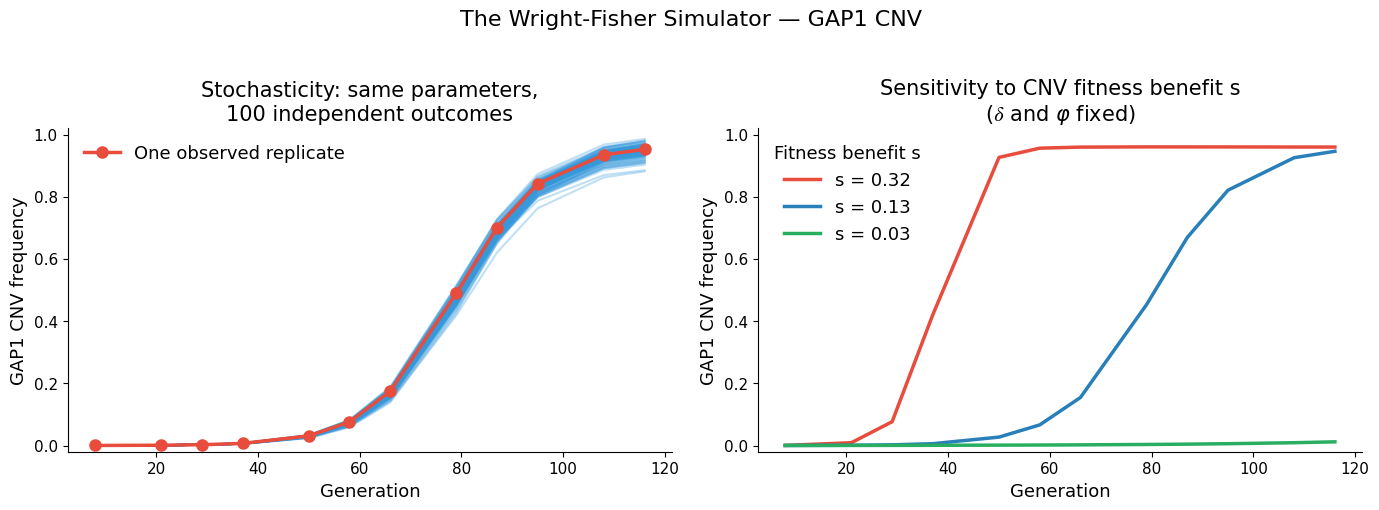

Key insight: same θ → variable outcomes (need Bayesian inference!)
             different θ → different average trajectories (identifiability)


In [180]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

TRUE = dict(log_s=-0.9, log_m=-5.0, log_p0=-5.5)

# ── Panel A: Stochasticity ── same θ, different realisations ────────────────
ax = axes[0]
for seed in range(100):
    traj = WF(**TRUE, seed=seed)
    ax.plot(GENERATIONS, traj, alpha=0.3, lw=1.5, color=C['sim'])

# One highlighted "observed" trajectory
x_example = WF(**TRUE, seed=7)
ax.plot(GENERATIONS, x_example, 'o-', color=C['data'], ms=8, lw=2.5,
        zorder=5, label='One observed replicate')

ax.set_xlabel('Generation')
ax.set_ylabel('GAP1 CNV frequency')
ax.set_title('Stochasticity: same parameters,\n100 independent outcomes')
ax.set_ylim(-0.02, 1.02)
ax.legend()

# ── Panel B: Sensitivity to s ────────────────────────────────────────────────
ax = axes[1]
param_sweep = [
    (-0.5, '#E74C3C', 's = 0.32'),
    (TRUE['log_s'], '#2980B9', f's = {10 ** TRUE["log_s"]:.2f}'),
    (-1.5, '#27AE60', 's = 0.03'),
]
for log_s, color, label in param_sweep:
    traj = WF(log_s=log_s, log_m=TRUE['log_m'], log_p0=TRUE['log_p0'], seed=42)
    ax.plot(GENERATIONS, traj, lw=2.5, color=color, label=label)

ax.set_xlabel('Generation')
ax.set_ylabel('GAP1 CNV frequency')
ax.set_title('Sensitivity to CNV fitness benefit s\n($𝛿$ and $\\varphi$ fixed)')
ax.legend(title='Fitness benefit s')
ax.set_ylim(-0.02, 1.02)

plt.suptitle('The Wright-Fisher Simulator — GAP1 CNV', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("Key insight: same θ → variable outcomes (need Bayesian inference!)")
print("             different θ → different average trajectories (identifiability)")


## 2. Approximate Bayesian Computation (ABC)

### Core idea: replace the likelihood with a distance

Since $p(x \mid \theta)$ is intractable, **simulate** and **compare**:

$$\theta \in \text{posterior} \iff d\!\left(x_\text{sim}(\theta),\, x_\text{obs}\right) < \varepsilon$$

```
Algorithm: Rejection ABC
────────────────────────
1. Draw θ ~ p(θ)                     [sample from prior]
2. Simulate x_sim ~ p(x | θ)         [run the WF model]
3. Compute d = RMSE(x_sim, x_obs)    [how close?]
4. Accept θ if d < ε                 [rejection step]
```

The accepted samples approximate $p(\theta \mid x_\text{obs})$ — exact in the limit $\varepsilon \to 0$.

---

| ✓ Pros | ✗ Cons |
|--------|--------|
| Intuitive and easy to implement | **Computationally expensive** (many simulations needed) |
| No training phase required | Distance function choice is an art |
| Exact in the $\varepsilon \to 0$ limit | **Not amortized**: must re-run for every new observation |
| Works with any black-box simulator | Curse of dimensionality for many parameters |


In [164]:
def rejection_abc(observed, n_sim=5_000, quantile=0.02, seed=None):
    """
    Rejection ABC for the Chuong et al. WF model.

    Parameters
    ----------
    observed  : 1-D array of observed CNV frequencies at GENERATIONS (length 12)
    n_sim     : number of prior samples to draw
    quantile  : acceptance fraction  (e.g. 0.02 → accept best 2%)

    Returns
    -------
    accepted  : (n_accepted, 3) array of accepted (log_s, log_m, log_p0)
    distances : (n_sim,) array of RMSE values for all simulations
    epsilon   : acceptance threshold used
    """
    if seed is not None:
        np.random.seed(seed)

    # Prior: BoxUniform in log₁₀ space  (matching the trained NPE posterior)
    prior_low  = np.array([-2.,  -7.,  -8.])
    prior_high = np.array([ 0.,  -2.,  -2.])

    # 1. Sample from prior
    thetas = np.random.uniform(prior_low, prior_high, (n_sim, 3))

    # 2. Simulate and compute RMSE distance
    distances = np.zeros(n_sim)
    for i in range(n_sim):
        log_s, log_m, log_p0 = thetas[i]
        x_sim = WF(log_s, log_m, log_p0)
        distances[i] = np.sqrt(np.mean((x_sim - observed) ** 2))

    # 3. Accept the best `quantile` fraction
    epsilon  = np.quantile(distances, quantile)
    accepted = thetas[distances <= epsilon]

    return accepted, distances, epsilon


In [183]:
# ── Synthetic "ground truth" observation ────────────────────────────────────
# Choose true parameters in the middle of the prior range
TRUE_LOG_S  = -0.9   # s   = 0.13  (strong CNV benefit)
TRUE_LOG_M  = -5.0   # μ   ≈ 1e-5  (moderate mutation rate)
TRUE_LOG_P0 = -5.5   # p₀  = 5e-5  (rare initial CNV)

x_obs_synth = WF(TRUE_LOG_S, TRUE_LOG_M, TRUE_LOG_P0, seed=42)

print(f"True parameters:  log_s={TRUE_LOG_S},  log_𝛿={TRUE_LOG_M},  log_𝜑={TRUE_LOG_P0}")
print(f"Observed CNV freq (gen 8 → 116): {x_obs_synth.round(3)}")

# ── Run ABC ──────────────────────────────────────────────────────────────────
N_SIM_ABC = 30_000
print(f"\nRunning ABC ({N_SIM_ABC:,} simulations, {2:.0f}% acceptance) ...")
print("(Each simulation runs the WF model for 116 generations with N=10⁷)")

abc_samples, abc_distances, abc_eps = rejection_abc(
    x_obs_synth, n_sim=N_SIM_ABC, quantile=0.02, seed=0)

print(f"\nResults:")
print(f"  Acceptance threshold (ε): {abc_eps:.4f}")
print(f"  Accepted samples:         {len(abc_samples)}")
print(f"  Acceptance rate:          {len(abc_samples)/N_SIM_ABC:.1%}")


True parameters:  log_s=-0.9,  log_𝛿=-5.0,  log_𝜑=-5.5
Observed CNV freq (gen 8 → 116): [0.    0.001 0.002 0.006 0.027 0.066 0.154 0.453 0.669 0.821 0.926 0.946]

Running ABC (30,000 simulations, 2% acceptance) ...
(Each simulation runs the WF model for 116 generations with N=10⁷)

Results:
  Acceptance threshold (ε): 0.1009
  Accepted samples:         600
  Acceptance rate:          2.0%


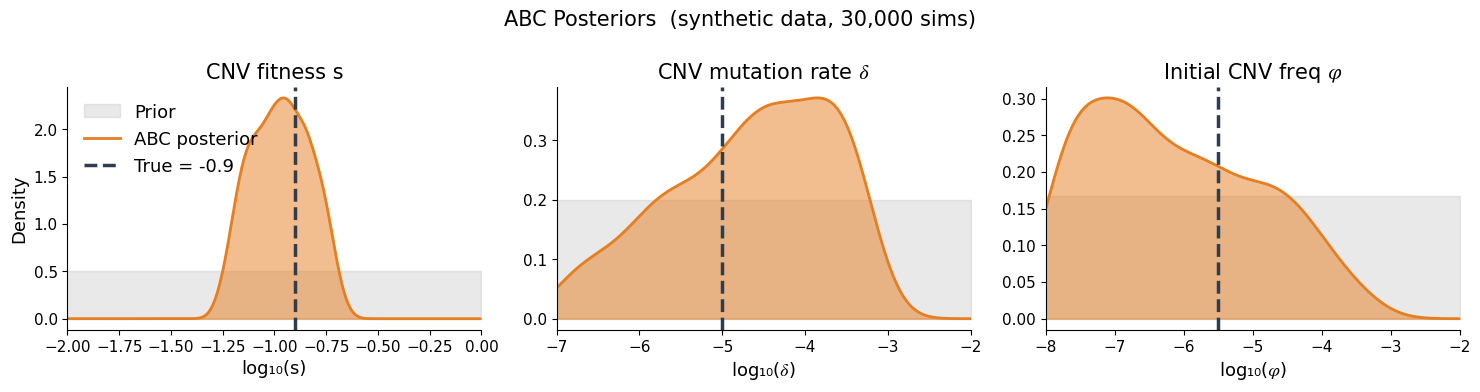


ABC posterior summary:
  log₁₀(s): mean = -0.97 ± 0.14   (true = -0.9)
  log₁₀(𝛿): mean = -4.67 ± 0.98   (true = -5.0)
  log₁₀(𝜑): mean = -6.13 ± 1.23   (true = -5.5)


In [188]:
PARAM_NAMES  = ['log₁₀(s)',      'log₁₀($𝛿$)',         'log₁₀($𝜑$)']
PARAM_LABELS = ['CNV fitness s', 'CNV mutation rate $𝛿$', 'Initial CNV freq $𝜑$']
TRUE_VALS    = [TRUE_LOG_S, TRUE_LOG_M, TRUE_LOG_P0]
PRIOR_BOUNDS = [(-2, 0),         (-7, -2),              (-8, -2)]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax_idx in range(3):
    ax = axes[ax_idx]
    lo, hi = PRIOR_BOUNDS[ax_idx]
    x_range = np.linspace(lo, hi, 300)

    # Prior (flat)
    prior_h = np.ones_like(x_range) / (hi - lo)
    ax.fill_between(x_range, prior_h, alpha=0.25, color=C['prior'], label='Prior')

    # ABC posterior
    abc_col = abc_samples[:, ax_idx]
    kde_abc = gaussian_kde(abc_col, bw_method=0.3)
    ax.fill_between(x_range, kde_abc(x_range), alpha=0.5, color=C['abc'])
    ax.plot(x_range, kde_abc(x_range), lw=2, color=C['abc'], label='ABC posterior')

    # True value
    ax.axvline(TRUE_VALS[ax_idx], ls='--', lw=2.5, color=C['true'],
               label=f'True = {TRUE_VALS[ax_idx]:.1f}')

    ax.set_xlabel(PARAM_NAMES[ax_idx])
    ax.set_ylabel('Density' if ax_idx == 0 else '')
    ax.set_title(PARAM_LABELS[ax_idx])
    ax.set_xlim(lo, hi)

axes[0].legend(loc='upper left')
plt.suptitle(f'ABC Posteriors  (synthetic data, {N_SIM_ABC:,} sims)', fontsize=15)
plt.tight_layout()
plt.show()

print("\nABC posterior summary:")
for idx, pname in enumerate(['log₁₀(s)', 'log₁₀(𝛿)', 'log₁₀(𝜑)']):
    col = abc_samples[:, idx]
    print(f"  {pname}: mean = {col.mean():.2f} ± {col.std():.2f}   (true = {TRUE_VALS[idx]:.1f})")


## 3. Neural Posterior Estimation (NPE)

### The key insight: *amortize* the computational cost

ABC repeats expensive simulations for every new observation.
**NPE** trains a neural network **once** and then performs inference in microseconds.

### How it works

1. **Training** (expensive, done once):
   Sample $N$ pairs $(\theta_i, x_i)$ from the joint $p(\theta)\,p(x|\theta)$, and train a conditional density estimator:
   $$q_\phi(\theta \mid x) \approx p(\theta \mid x)$$
   using a **normalizing flow** (Masked Autoregressive Flow) — a neural network mapping a Gaussian
   into an arbitrary posterior shape, conditioned on $x$.

2. **Inference** (cheap, amortized):
   For any new $x_\text{obs}$, condition the trained network: a single forward pass gives the full posterior $q_\phi(\theta \mid x_\text{obs})$.

### Training objective

$$\mathcal{L}(\phi) = -\,\mathbb{E}_{p(\theta,\,x)}\!\left[\log q_\phi(\theta \mid x)\right]$$

Minimised over simulated $(\theta, x)$ pairs.

---

|  | **ABC** | **NPE** |
|---|---|---|
| Simulations per inference | 100,000 (≈1 min) | ≈ 0 (amortized) |
| One-time training cost | None | 30,000 sims (≈15 mins) |
| Posterior quality | Approximate (depends on ε) | Asymptotically exact |
| Cost of new observations | Full re-run | One forward pass |


In [190]:
# ── Training code (for reference — we load a pre-trained model below) ────────

TRAINING_CODE = '''
from sbi.inference import NPE
from sbi.utils import BoxUniform
from simulator import WF
import numpy as np
import torch
import pickle

# 1. Prior over (s, 𝛿, 𝜑) in log₁₀ space
prior = BoxUniform(
    low  = torch.tensor([-2., -7., -8.]),
    high = torch.tensor([ 0., -2., -2.])
)

# 2. Simulate 30,000 (θ, x) pairs
n_sim = 30_000
theta_sim = prior.sample((n_sim,))
x_sim     = torch.zeros(n_sim, len(GENERATIONS))

for i in tqdm(range(n_sim)):
    log_s, log_m, log_p0 = theta_sim[i].numpy()
    x_sim[i] = torch.tensor(WF(log_s, log_m, log_p0), dtype=torch.float32)

# 3. Train a Masked Autoregressive Flow
inference   = NPE(prior, density_estimator="maf")
density_est = inference.append_simulations(theta_sim, x_sim).train(stop_after_epochs=20)
posterior   = inference.build_posterior(density_est)

# 4. Save for reuse
with open("posteriors/posterior_WF_30000_20.pkl", "wb") as f:
    pickle.dump(posterior, f)
'''

print("NPE training code (30 k sims, density estimator = MAF):")
print(TRAINING_CODE)


NPE training code (30 k sims, density estimator = MAF):

from sbi.inference import NPE
from sbi.utils import BoxUniform
from simulator import WF
import numpy as np
import torch
import pickle

# 1. Prior over (s, 𝛿, 𝜑) in log₁₀ space
prior = BoxUniform(
    low  = torch.tensor([-2., -7., -8.]),
    high = torch.tensor([ 0., -2., -2.])
)

# 2. Simulate 30,000 (θ, x) pairs
n_sim = 30_000
theta_sim = prior.sample((n_sim,))
x_sim     = torch.zeros(n_sim, len(GENERATIONS))

for i in tqdm(range(n_sim)):
    log_s, log_m, log_p0 = theta_sim[i].numpy()
    x_sim[i] = torch.tensor(WF(log_s, log_m, log_p0), dtype=torch.float32)

# 3. Train a Masked Autoregressive Flow
inference   = NPE(prior, density_estimator="maf")
density_est = inference.append_simulations(theta_sim, x_sim).train(stop_after_epochs=20)
posterior   = inference.build_posterior(density_est)

# 4. Save for reuse
with open("posteriors/posterior_WF_30000_20.pkl", "wb") as f:
    pickle.dump(posterior, f)



In [ ]:
POSTERIOR_PATH = 'posterior_WF_30000_20.pkl'

with open(POSTERIOR_PATH, 'rb') as f:
    npe_posterior = pickle.load(f)

print("✓ Pre-trained NPE posterior loaded")
print(f"  Trained on : 30,000 simulations")
print(f"  Density est: Masked Autoregressive Flow (MAF)")
print(f"  Parameters : log_s, log_m, log_p0  (log₁₀ scale)")
print(f"  Obs. dim.  : {len(GENERATIONS)} time points  {list(GENERATIONS)}")
print(f"  Population : N = 10⁷")


In [192]:
# ── Condition NPE on the same synthetic observation used for ABC ─────────────
x_obs_tensor = torch.tensor(x_obs_synth, dtype=torch.float32)

N_NPE = 600
npe_samples = npe_posterior.set_default_x(x_obs_tensor).sample((N_NPE,)).numpy()

print(f"NPE posterior: {npe_samples.shape} samples")
print("\nPosterior summaries (ABC vs NPE):")
header = (f"{'Parameter':<14}  {'True':>6}  "
          f"{'ABC mean':>10}  {'NPE mean':>10}  {'ABC std':>8}  {'NPE std':>8}")
print(header); print("─" * len(header))
for idx, pname in enumerate(PARAM_NAMES):
    print(f"{pname:<14}  {TRUE_VALS[idx]:>6.1f}  "
          f"{abc_samples[:, idx].mean():>10.2f}  {npe_samples[:, idx].mean():>10.2f}  "
          f"{abc_samples[:, idx].std():>8.3f}  {npe_samples[:, idx].std():>8.3f}")


Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

NPE posterior: (600, 3) samples

Posterior summaries (ABC vs NPE):
Parameter         True    ABC mean    NPE mean   ABC std   NPE std
──────────────────────────────────────────────────────────────────
log₁₀(s)          -0.9       -0.97       -0.90     0.141     0.031
log₁₀($𝛿$)        -5.0       -4.67       -5.07     0.979     0.252
log₁₀($𝜑$)        -5.5       -6.13       -6.11     1.225     0.558


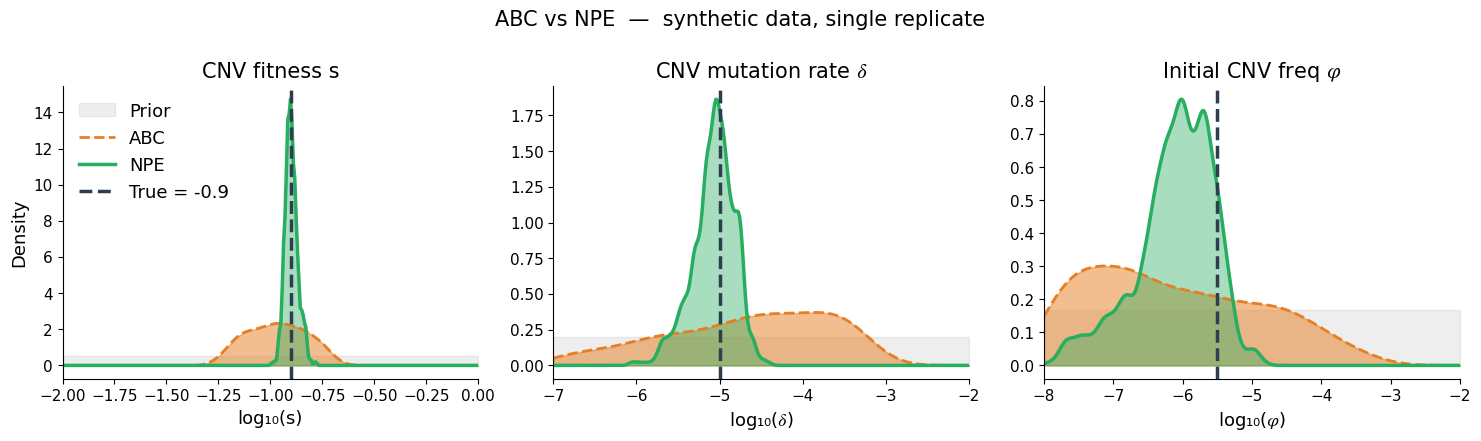


→ NPE is AMORTIZED: condition on any new observation with one forward pass
→ No new simulations needed after training!


In [194]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

for ax_idx in range(3):
    ax = axes[ax_idx]
    lo, hi = PRIOR_BOUNDS[ax_idx]
    x_range = np.linspace(lo, hi, 300)

    # Prior
    ax.fill_between(x_range, np.ones_like(x_range) / (hi - lo),
                    alpha=0.2, color=C['prior'], label='Prior')

    # ABC
    kde_abc = gaussian_kde(abc_samples[:, ax_idx], bw_method=0.3)
    ax.fill_between(x_range, kde_abc(x_range), alpha=0.5, color=C['abc'])
    ax.plot(x_range, kde_abc(x_range), lw=2, ls='--', color=C['abc'], label='ABC')

    # NPE
    kde_npe = gaussian_kde(npe_samples[:, ax_idx], bw_method=0.15)
    ax.fill_between(x_range, kde_npe(x_range), alpha=0.4, color=C['npe'])
    ax.plot(x_range, kde_npe(x_range), lw=2.5, color=C['npe'], label='NPE')

    # True value
    ax.axvline(TRUE_VALS[ax_idx], ls='--', lw=2.5, color=C['true'],
               label=f'True = {TRUE_VALS[ax_idx]:.1f}')

    ax.set_xlabel(PARAM_NAMES[ax_idx])
    ax.set_ylabel('Density' if ax_idx == 0 else '')
    ax.set_title(PARAM_LABELS[ax_idx])
    ax.set_xlim(lo, hi)

axes[0].legend(loc='upper left')
plt.suptitle('ABC vs NPE  —  synthetic data, single replicate', fontsize=15)
plt.tight_layout()
plt.show()

print("\n→ NPE is AMORTIZED: condition on any new observation with one forward pass")
print("→ No new simulations needed after training!")


## 4. The Collective Posterior: Combining Multiple Replicates

### The multi-replicate setting

Experimental evolution is almost always run with **many independent replicates** of the same experiment.
Each replicate $i$ gives an independent observation $x_i$ from the *same underlying parameters* $\theta$.

The LTRΔ line has **7 replicates** — we want to use all of them together.

### Naïve approach — just multiply posteriors?

$$p(\theta \mid x_1, \ldots, x_r) \stackrel{?}{\propto} \prod_{i=1}^r p(\theta \mid x_i)$$

**This is wrong!** Multiplying $r$ individual posteriors counts the prior $r$ times,
giving a posterior that is drastically over-sharpened.

### The correct derivation

By Bayes rule on the full joint:

$$p(\theta \mid x_1, \ldots, x_r) \;\propto\; \prod_{i=1}^r p(x_i \mid \theta) \cdot p(\theta)$$

Substituting $p(x_i \mid \theta) = p_i(\theta \mid x_i) \cdot p(x_i) / p(\theta)$:

$$\boxed{\log p(\theta\mid x_1, \ldots, x_r) = \sum_{i=1}^r \log p_i(\theta \mid x_i) - (r-1)\log p(\theta) - \log C}$$

The $(r-1)\log p(\theta)$ term **removes $r-1$ excess prior copies**.
$C$ is a normalising constant.

### Intuition table

| Component | Role |
|-----------|------|
| $\sum_i \log p_i(\theta \mid x_i)$ | Aggregate evidence from all $r$ replicates |
| $-(r-1)\log p(\theta)$ | Undo $r-1$ extra priors |
| $-\log C$ | Ensure the result normalises to a proper distribution |

### Why this matters for Chuong et al.

- **8 ALLΔ replicates** — the collective posterior should be ≈$\sqrt{8}\approx 2.8\times$ narrower
- Replicates have somewhat different trajectories (biological variability)
- The collective posterior gives a single rigorous summary of all evidence


In [ ]:
# ── Import the CollectivePosterior used in Chuong et al. analysis ───────────
from collective_posterior import CollectivePosterior

# Key API (collective_posterior.py):
# ─────────────────────────────────────────────────────────────────────────────
#
#   cp = CollectivePosterior(prior, Xs, amortized_posterior=posterior,
#                             log_C=None,      ← MUST call get_log_C() first
#                             epsilon=-10000,   ← log-density floor
#                             n_eval=int(1e5))  ← MC samples for log C
#
#   cp.get_log_C(n_reps=10)        → estimate log C (also seeds MCMC candidates)
#   cp.rejection_sample(n_samples) → torch.Tensor of samples from collective posterior
#   cp.get_map()                   → MAP estimate via Nelder-Mead optimisation
#
# Core log-probability formula:
#   log p_collective(θ) = Σᵢ log pᵢ(θ|xᵢ)  +  (r−1)·log p(θ)  +  log C
# (individual log pᵢ values are clamped at epsilon to avoid −∞)
# ─────────────────────────────────────────────────────────────────────────────

print("✓ CollectivePosterior imported from collective_posterior.py")


In [196]:
from sbi.utils import BoxUniform

# ── Generate r=4 synthetic replicates with the same true θ ───────────────────
N_REPS = 8
print(f"Generating {N_REPS} synthetic replicates")
print(f"  True: log_s={TRUE_LOG_S}, log_m={TRUE_LOG_M}, log_p0={TRUE_LOG_P0}")

x_reps = [
    torch.tensor(WF(TRUE_LOG_S, TRUE_LOG_M, TRUE_LOG_P0, seed=seed),
                 dtype=torch.float32)
    for seed in range(N_REPS)
]
Xs_synth = torch.stack(x_reps)   # (4, 12)

# ── Individual posteriors (NPE conditioned on each replicate) ─────────────────
print("\nSampling individual posteriors ...")
ind_samples = [
    npe_posterior.set_default_x(Xs_synth[i]).sample((600,)).numpy()
    for i in range(N_REPS)
]
print("✓ Individual posteriors sampled")

# ── Collective posterior ──────────────────────────────────────────────────────
prior_cp = BoxUniform(
    low  = torch.tensor([-2., -7., -8.]),
    high = torch.tensor([ 0., -2., -2.])
)

cp = CollectivePosterior(prior_cp, Xs_synth, amortized_posterior=npe_posterior, epsilon=-10)

print("\nEstimating normalising constant log C ...")
log_C = cp.get_log_C()
print(f"  log C ≈ {log_C:.2f}")

print("\nSampling from collective posterior ...")
coll_samples = cp.rejection_sample(600).numpy()
print(f"✓ Collective posterior: {coll_samples.shape}")


Generating 8 synthetic replicates
  True: log_s=-0.9, log_m=-5.0, log_p0=-5.5

Sampling individual posteriors ...


Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

✓ Individual posteriors sampled

Estimating normalising constant log C ...
  log C ≈ 52.12

Sampling from collective posterior ...


Rejection Sampling: 610it [00:07, 87.00it/s]                          

✓ Collective posterior: (600, 3)


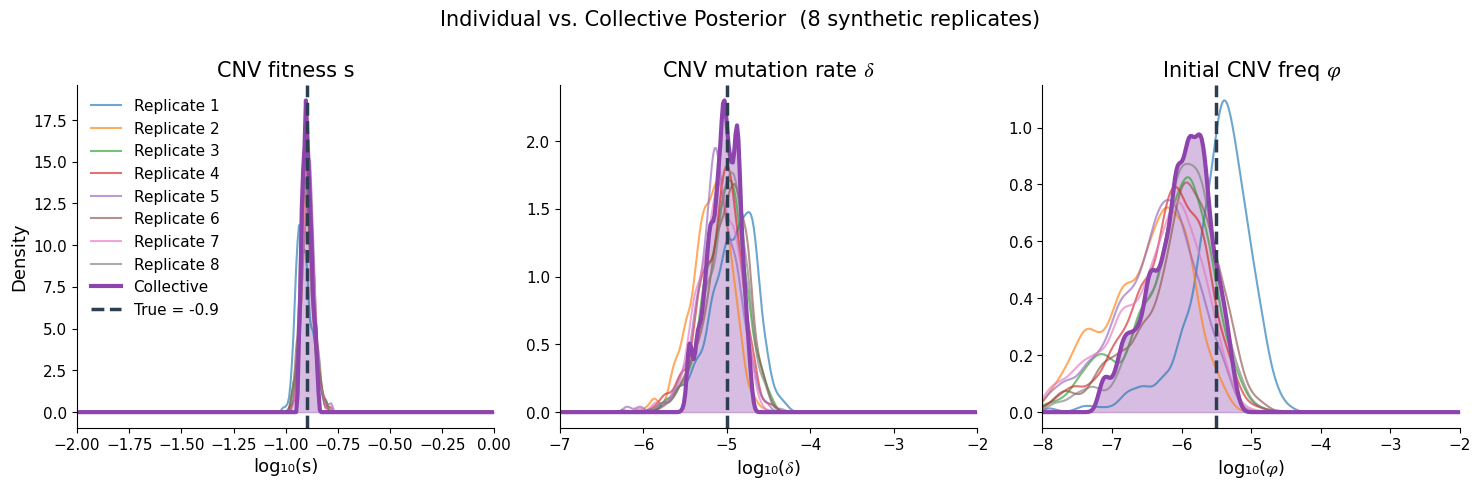


Precision gain (posterior std):
Parameter           Indiv. (mean ± sd)    Collective   Fold gain
──────────────────────────────────────────────────────────────────
log₁₀(s)             0.031 ± 0.003         0.022        1.4×
log₁₀($𝛿$)           0.250 ± 0.011         0.177        1.4×
log₁₀($𝜑$)           0.569 ± 0.038         0.432        1.3×


In [197]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax_idx in range(3):
    ax = axes[ax_idx]
    lo, hi = PRIOR_BOUNDS[ax_idx]
    x_range = np.linspace(lo, hi, 300)

    # Individual posteriors (thin, colored)
    for i, samps in enumerate(ind_samples):
        kde = gaussian_kde(samps[:, ax_idx], bw_method=0.2)
        ax.plot(x_range, kde(x_range), lw=1.5, alpha=0.65,
                color=REP_COLORS[i],
                label=f'Replicate {i+1}' if ax_idx == 0 else None)

    # Collective posterior (bold, purple)
    kde_c = gaussian_kde(coll_samples[:, ax_idx], bw_method=0.15)
    ax.fill_between(x_range, kde_c(x_range), alpha=0.35, color=C['coll'])
    ax.plot(x_range, kde_c(x_range), lw=3, color=C['coll'],
            label='Collective' if ax_idx == 0 else None)

    # True value
    ax.axvline(TRUE_VALS[ax_idx], ls='--', lw=2.5, color=C['true'],
               label=f'True = {TRUE_VALS[ax_idx]:.1f}' if ax_idx == 0 else None)

    ax.set_xlabel(PARAM_NAMES[ax_idx])
    ax.set_ylabel('Density' if ax_idx == 0 else '')
    ax.set_title(PARAM_LABELS[ax_idx])
    ax.set_xlim(lo, hi)

axes[0].legend(loc='upper left', fontsize=11)
plt.suptitle(f'Individual vs. Collective Posterior  ({N_REPS} synthetic replicates)',
             fontsize=15)
plt.tight_layout()
plt.show()

# ── Quantify precision gain ──────────────────────────────────────────────────
print("\nPrecision gain (posterior std):")
print(f"{'Parameter':<14}  {'Indiv. (mean ± sd)':>22}  {'Collective':>12}  {'Fold gain':>10}")
print("─" * 66)
for ax_idx, pname in enumerate(PARAM_NAMES):
    ind_stds = [np.std(s[:, ax_idx]) for s in ind_samples]
    coll_std = np.std(coll_samples[:, ax_idx])
    fold     = np.mean(ind_stds) / coll_std
    print(f"{pname:<14}  {np.mean(ind_stds):>10.3f} ± {np.std(ind_stds):.3f}  "
          f"{coll_std:>12.3f}  {fold:>9.1f}×")


## 5. Application to Real Data — LTRΔ Line (Chuong et al.)

### The LTRΔ background

In the LTRΔ strain, an **upstream Long Terminal Repeat element** that normally represses *GAP1*
is deleted. This changes the regulatory landscape for CNV formation.

- **7 independent replicate populations** evolved for 116 generations
- CNV frequency measured at 12 time points by barcode sequencing
- High variability across replicates (range: 40%–85% by generation 116)

**Goal:** Use NPE to infer $(s, \mu, p_0)$ for each replicate, then combine with the
Collective Posterior for a joint estimate across all 7 replicates.


In [ ]:
all_df = pd.read_csv('data/all.csv', index_col=0)
all_df.columns = all_df.columns.astype(int)   # column names are generation numbers

print(f"ALLΔ replicates: {list(all_df.index)}")
print(f"Generations    : {list(all_df.columns)}")
print(f"\nData (CNV fractions):")
print(all_df.round(3).to_string())

# ── Plot all 8 replicates ────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: raw trajectories
ax = axes[0]
for j, (strain, row) in enumerate(all_df.iterrows()):
    ax.plot(all_df.columns, row.values, 'o-',
            color=REP_COLORS[j], ms=7, lw=2, label=strain)
ax.set_xlabel('Generation')
ax.set_ylabel('GAP1 CNV frequency')
ax.set_title('ALLΔ — 8 independent replicates')
ax.set_ylim(-0.02, 1.02)
ax.legend(fontsize=9, ncol=2)

# Panel B: spread across replicates
ax = axes[1]
mean_traj = all_df.mean(axis=0)
std_traj  = all_df.std(axis=0)
ax.fill_between(all_df.columns,
                mean_traj - std_traj, mean_traj + std_traj,
                alpha=0.3, color=C['coll'], label='Mean ± 1 SD')
ax.plot(all_df.columns, mean_traj, 'o-', color=C['coll'], lw=2.5, ms=7)
for j, (_, row) in enumerate(all_df.iterrows()):
    ax.plot(all_df.columns, row.values, '-', color=REP_COLORS[j], alpha=0.4, lw=1)
ax.set_xlabel('Generation')
ax.set_ylabel('GAP1 CNV frequency')
ax.set_title('ALLΔ — replicate spread')
ax.set_ylim(-0.02, 1.02)
ax.legend()

plt.suptitle('Empirical Data: ALLΔ line  (Chuong et al. 2025)', fontsize=14)
plt.tight_layout()
plt.show()

# Prepare as tensor (r × 12)
all_Xs = torch.tensor(all_df.values, dtype=torch.float32)
print(f"\nObservation tensor: {all_Xs.shape}  (8 replicates × 12 time points)")


In [150]:
# ── Individual NPE posteriors for each ALLΔ replicate ───────────────────────
strains = list(all_df.index)
print(f"Computing NPE posteriors for {len(strains)} ALLΔ replicates ...")

real_ind_samples = {}
for j, strain in enumerate(strains):
    x_i   = all_Xs[j]                                    # tensor(12,)
    samps = npe_posterior.set_default_x(x_i).sample((600,)).numpy()
    real_ind_samples[strain] = samps

print("✓ Individual posteriors computed")

# ── Posterior mean per replicate ─────────────────────────────────────────────
print("\nPosterior means per replicate (log₁₀ scale):")
print(f"{'Replicate':<18}  {'log_s':>8}  {'log_m':>8}  {'log_p0':>8}")
print("─" * 50)
for strain in strains:
    m = real_ind_samples[strain].mean(axis=0)
    print(f"{strain:<18}  {m[0]:>8.2f}  {m[1]:>8.2f}  {m[2]:>8.2f}")


Computing NPE posteriors for 8 ALLΔ replicates ...


Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

✓ Individual posteriors computed

Posterior means per replicate (log₁₀ scale):
Replicate              log_s     log_m    log_p0
──────────────────────────────────────────────────
gap1_all_1             -0.94     -4.48     -5.10
gap1_all_2             -1.14     -4.05     -4.70
gap1_all_3             -1.03     -4.47     -6.46
gap1_all_4             -0.90     -5.16     -5.80
gap1_all_5             -0.67     -5.82     -5.56
gap1_all_6             -0.85     -5.30     -6.05
gap1_all_7             -0.91     -5.04     -5.75
gap1_all_8             -0.83     -5.07     -5.85


Building collective posterior over 8 ALLΔ replicates ...
  Estimated epsilon (log-density floor): -12.10
Estimating log C ...
  log C ≈ -22.14
Sampling from collective posterior ...


Rejection Sampling: 687it [00:02, 244.39it/s]                         


✓ Collective posterior samples: (600, 3)


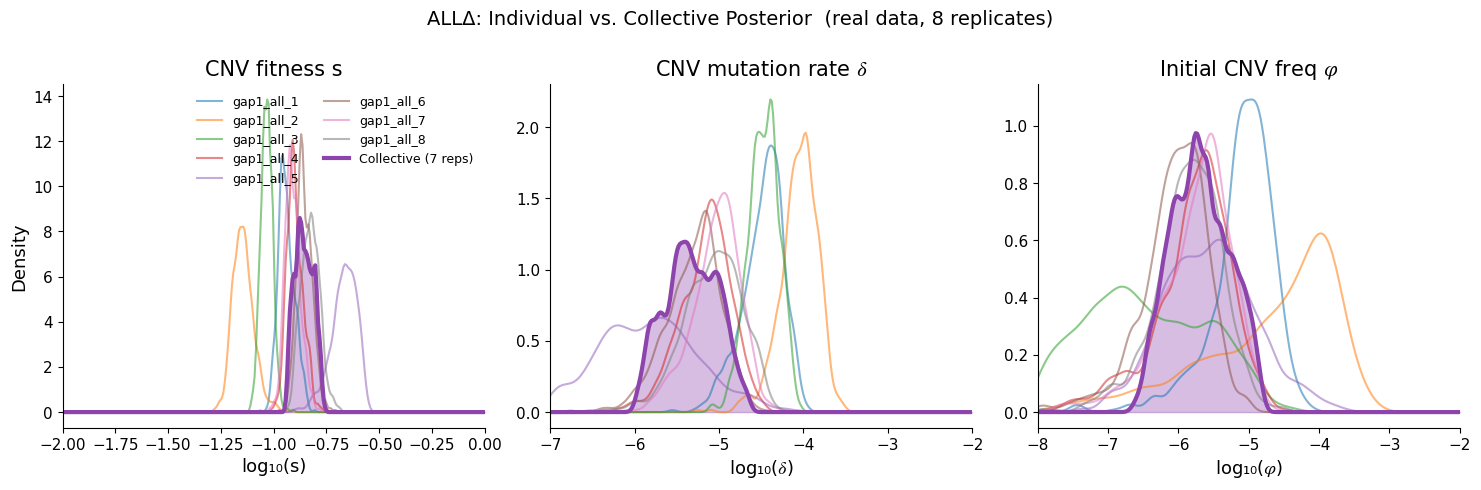


Collective Posterior MAP estimate (ALLΔ):
  CNV fitness benefit  s:  10^-0.88 = 0.131   (log₁₀(s) = -0.88)
  CNV mutation rate    μ:  10^-5.09 = 8.168e-06   (log₁₀($𝛿$) = -5.09)
  Initial CNV freq    p₀:  10^-5.52 = 3.03e-06   (log₁₀($𝜑$) = -5.52)


In [199]:
# ── Build collective posterior over all 7 ALLΔ replicates ───────────────────
print(f"Building collective posterior over {len(strains)} ALLΔ replicates ...")

cp_all = CollectivePosterior(prior_cp, all_Xs, amortized_posterior=npe_posterior, epsilon=-10)
cp_all.epsilon = cp_all.estimate_epsilon(all_Xs, quant=0.99)[0]
print(f"  Estimated epsilon (log-density floor): {cp_all.epsilon:.2f}")

print("Estimating log C ...")
log_C_all = cp_all.get_log_C()
print(f"  log C ≈ {log_C_all:.2f}")

print("Sampling from collective posterior ...")
coll_all = cp_all.rejection_sample(600).numpy()
print(f"✓ Collective posterior samples: {coll_all.shape}")

# ── Plot: individual vs collective ──────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax_idx in range(3):
    ax = axes[ax_idx]
    lo, hi = PRIOR_BOUNDS[ax_idx]
    x_range = np.linspace(lo, hi, 300)

    # All 7 individual posteriors
    for j, strain in enumerate(strains):
        samps = real_ind_samples[strain]
        kde   = gaussian_kde(samps[:, ax_idx], bw_method=0.2)
        ax.plot(x_range, kde(x_range), lw=1.5, alpha=0.55,
                color=REP_COLORS[j],
                label=strain if ax_idx == 0 else None)

    # Collective posterior
    kde_c = gaussian_kde(coll_all[:, ax_idx], bw_method=0.15)
    ax.fill_between(x_range, kde_c(x_range), alpha=0.35, color=C['coll'])
    ax.plot(x_range, kde_c(x_range), lw=3, color=C['coll'],
            label='Collective (7 reps)' if ax_idx == 0 else None)

    ax.set_xlabel(PARAM_NAMES[ax_idx])
    ax.set_ylabel('Density' if ax_idx == 0 else '')
    ax.set_title(PARAM_LABELS[ax_idx])
    ax.set_xlim(lo, hi)

axes[0].legend(fontsize=9, ncol=2)
plt.suptitle('ALLΔ: Individual vs. Collective Posterior  (real data, 8 replicates)',
             fontsize=14)
plt.tight_layout()
plt.show()

# ── Collective MAP ────────────────────────────────────────────────────────────
log_p = cp_all.log_prob(torch.tensor(coll_all, dtype=torch.float32)).numpy().ravel()
map_est = coll_all[np.argmax(log_p)]

print("\nCollective Posterior MAP estimate (ALLΔ):")
descs = ['CNV fitness benefit  s', 'CNV mutation rate    μ', 'Initial CNV freq    p₀']
for pname, log_val, desc in zip(PARAM_NAMES, map_est, descs):
    print(f"  {desc}:  10^{log_val:.2f} = {10**log_val:.4g}   ({pname} = {log_val:.2f})")



Posterior predictive check: simulating trajectories from collective posterior samples ...


  0%|          | 0/600 [00:00<?, ?it/s]

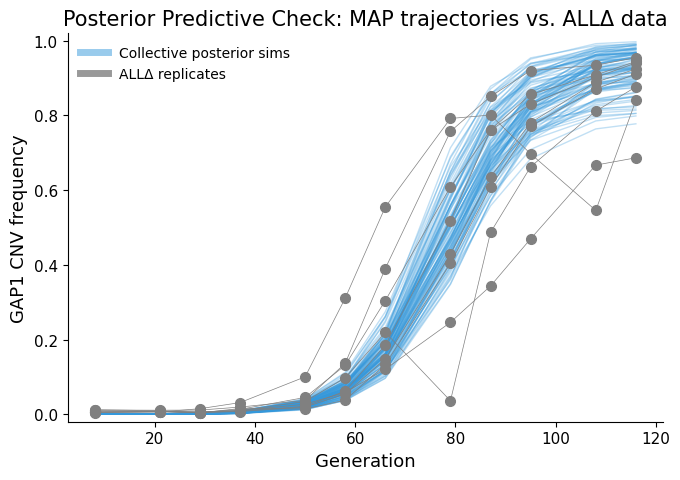

In [211]:
# Posterior predictive check: simulate trajectories from collctive posterior samples and compare to data
print("\nPosterior predictive check: simulating trajectories from collective posterior samples ...")

map_trajs = np.zeros((len(coll_all), len(GENERATIONS)))
for i in tqdm(range(len(coll_all))):
    log_s, log_m, log_p0 = coll_all[i]
    map_trajs[i] = WF(log_s, log_m, log_p0)

# Plot MAP trajectories vs data
fig, ax = plt.subplots(figsize=(7, 5))
for i in range(100):
    ax.plot(GENERATIONS, map_trajs[i], color=C['sim'], alpha=0.3, lw=1, label='Collective posterior sims' if i == 0 else None)
for j, strain in enumerate(strains):
    ax.plot(all_df.columns.astype('int'), all_df.loc[strain].values, 'o-',
            color='grey', ms=7, lw=0.5, label='ALLΔ replicates' if j == 0 else None)
ax.set_xlabel('Generation')
ax.set_ylabel('GAP1 CNV frequency')
ax.set_title('Posterior Predictive Check: MAP trajectories vs. ALLΔ data')
ax.set_ylim(-0.02, 1.02)

# Make lines bolder in legend but not in the plot
handles, labels = ax.get_legend_handles_labels()
new_handles = []
for h in handles:
    if h.get_label() == 'Collective posterior sims':
        new_handles.append(plt.Line2D([], [], color=C['sim'], lw=5, alpha=0.5))
    elif h.get_label() == 'ALLΔ replicates':
        new_handles.append(plt.Line2D([], [], color='grey', lw=5, alpha=0.8))
    else:
        new_handles.append(h)
ax.legend(handles=new_handles, labels=labels, fontsize=10)
plt.tight_layout()
plt.show()

## Summary & Conclusions

---

### The SBI Toolkit for Experimental Evolution

| Method | Core idea | When to use |
|--------|-----------|-------------|
| **ABC** | Reject simulations far from data | Quick prototyping; few parameters |
| **NPE** | Neural posterior estimator trained on simulations | Amortized — fast inference over many strains/conditions |
| **Collective Posterior** | Combine $r$ NPE/ABC posteriors | Multiple replicates of the same experiment |

---

### Key takeaways

1. **Stochastic models need SBI** — Wright-Fisher and its extensions have no analytical likelihood.

2. **NPE dramatically outperforms ABC** — train once on 30k simulations, then evaluate any
   observation in milliseconds.

3. **Replicates are gold** — the Collective Posterior correctly integrates all $r$ replicates,
   yielding narrower posteriors for well-identifiable parameters.

4. **The framework is general** — it extends naturally to multi-chromosome models (Zhou et al.),
   CNV stability (De et al.), chemostat growth models, and beyond.

---

### Results for ALLΔ (Chuong et al., 2025)

Using the Collective Posterior over all 8 ALLΔ replicates:
- $s_\text{C}$ — fitness benefit of carrying a GAP1 CNV
- $\delta_\text{C}$ — per-generation rate at which CNVs arise
- $\varphi$ — initial CNV frequency at the start of the experiment

These estimates are **biologically interpretable** and come with **full uncertainty quantification**.

---

### Resources

- **SBI library** (`pip install sbi`): https://sbi-project.github.io
- **Collective Posterior paper**: Ben Nun et al., 2026 (under review)
- **Chuong et al. data**: Chuong et al., 2025 (eLife)

---
*Contact: Nadav Ben Nun*

*nadavbennun1@mail.tau.ac.il*
